Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining the dataset path

In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/"

Installing the required libraries

In [ ]:
!pip install tensorflow

Importing the required libraries

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
import numpy as np

Visualising Class Distribution

<ipython-input-5-450ad9564f85>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_series.index, y=counts_series.values, palette='cividis')


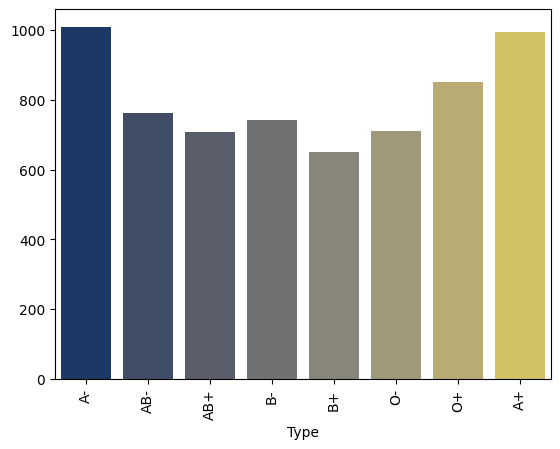

In [ ]:
# Get class names (folder names)
class_names = os.listdir(dataset_path)

# Count images in each class folder
counts = {}
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    counts[class_name] = len(os.listdir(class_path))

# Convert counts to a pandas Series for easier plotting
counts_series = pd.Series(counts)

# Create bar plot
sns.barplot(x=counts_series.index, y=counts_series.values, palette='cividis')
plt.xlabel('Type')
plt.xticks(rotation=90)
plt.show()

Load Pre-trained VGG16 Model

In [ ]:
# Load the base model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze all except last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Print model summary
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Set up Early Stop

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Adding custom layers for classification

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer for 8 classes (A-, A+, AB-, AB+, B-, B+, O-, O+)
output = Dense(8, activation='softmax')(x)  # Assuming 8 blood groups

# Create new model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 15,044,040 (57.39 MB)

 Trainable params: 7,408,776 (28.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Data preprocessing and augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # 20% validation

# Load dataset from Google Drive directory
train_generator = train_datagen.flow_from_directory(dataset_path,
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(dataset_path,
                                                         target_size=(128, 128),
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 5147 images belonging to 8 classes.
Found 1283 images belonging to 8 classes.


Training the Model

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator))

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 972s 6s/step - accuracy: 0.1901 - loss: 2.0061 - val_accuracy: 0.4825 - val_loss: 1.1843
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 65s 322ms/step - accuracy: 0.4380 - loss: 1.3471 - val_accuracy: 0.5448 - val_loss: 1.0722
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 79s 302ms/step - accuracy: 0.5024 - loss: 1.1824 - val_accuracy: 0.6118 - val_loss: 0.9321
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 81s 298ms/step - accuracy: 0.5570 - loss: 1.0790 - val_accuracy: 0.6602 - val_loss: 0.8529
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 301ms/step - accuracy: 0.6406 - loss: 0.9337 - val_accuracy: 0.7366 - val_loss: 0.6834
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 48s 297ms/step - accuracy: 0.7204 - loss: 0.7663 - val_accuracy: 0.7646 - val_loss: 0.5860
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 301ms/step - accuracy: 0.7531 - loss: 0.6745 - val_accuracy: 0.8012 - val_loss: 0.5269
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 306ms/step - accuracy: 0.7772 - loss: 0.5

Visualising the Model Performance during Training

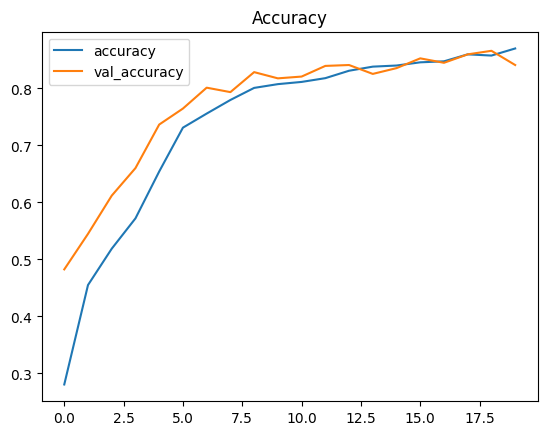

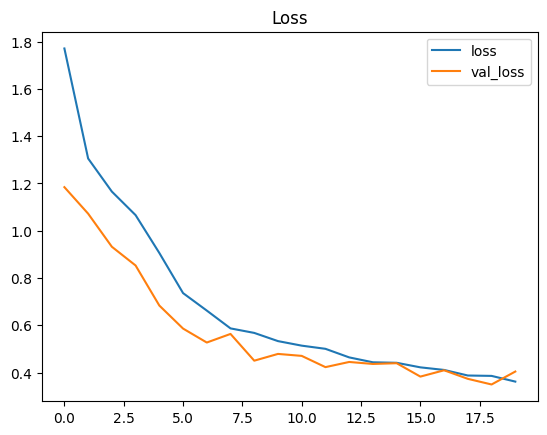

Test Loss: 0.36260
Test Accuracy: 86.28%
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step
              precision    recall  f1-score   support

          A+       0.19      0.19      0.19       199
          A-       0.13      0.12      0.12       201
         AB+       0.15      0.16      0.15       141
         AB-       0.11      0.13      0.12       152
          B+       0.10      0.11      0.10       130
          B-       0.13      0.13      0.13       148
          O+       0.12      0.11      0.11       170
          O-       0.17      0.15      0.16       142

    accuracy                           0.14      1283
   macro avg       0.14      0.14      0.14      1283
weighted avg       0.14      0.14      0.14      1283



In [ ]:
# Plot training history: accuracy
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plot training history: loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

# Evaluate the model on test data
results = model.evaluate(validation_generator, verbose=0)
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

# Predict labels for test data
pred = model.predict(validation_generator)
pred = np.argmax(pred, axis=1)

# Map predicted labels
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Get true labels for validation data
y_test = []
for i in range(len(validation_generator)):
    _, batch_labels = validation_generator[i]  # Get true labels from the generator
    y_test.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot encoded labels to class indices

# Convert class indices to class names
y_test = [labels[k] for k in y_test]

# Compare predicted labels with true labels and print classification report
print(classification_report(y_test, pred))

Evaluating the Model

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.8555 - loss: 0.3940
Validation Accuracy: 86.36%


Saving the Model

In [ ]:
model_save_path = "/content/drive/MyDrive/blood_group_classification_using_fingerprints_VGG16.h5"
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/blood_group_classification_using_fingerprints_VGG16.h5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Opening a Sample Image for Detection

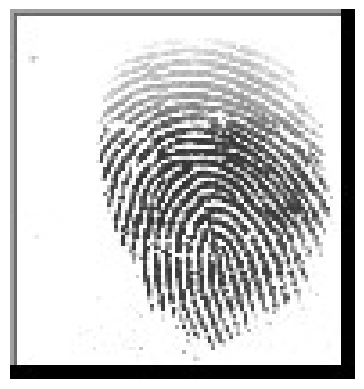

In [ ]:
from PIL import Image
img = Image.open("/content/drive/MyDrive/testdata/fponone.jpg").convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

Prediction of the Blood Group of the Sample Image

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path, model, train_gen):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(128, 128), color_mode="rgb")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)

    # Get class labels
    class_labels = {v: k for k, v in train_gen.class_indices.items()}  # Reverse mapping
    predicted_blood_group = class_labels.get(predicted_class_index, "Unknown")

    print(f"Raw Predictions: {predictions}")  # Debugging output
    print(f"Predicted Class Index: {predicted_class_index}")
    print(f"Predicted Blood Group: {predicted_blood_group}")

    return predicted_blood_group

# Example usage
test_image_path = "/content/drive/MyDrive/testdata/fponone.jpg"
predicted_blood_group = predict_image(test_image_path, model, train_generator)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Raw Predictions: [[3.0298517e-05 1.6576945e-04 1.4409820e-05 6.0482666e-02 9.6488839e-06
  6.4150067e-06 3.8340385e-04 9.3890750e-01]]
Predicted Class Index: 7
Predicted Blood Group: O-


Visualising the Overall Performance

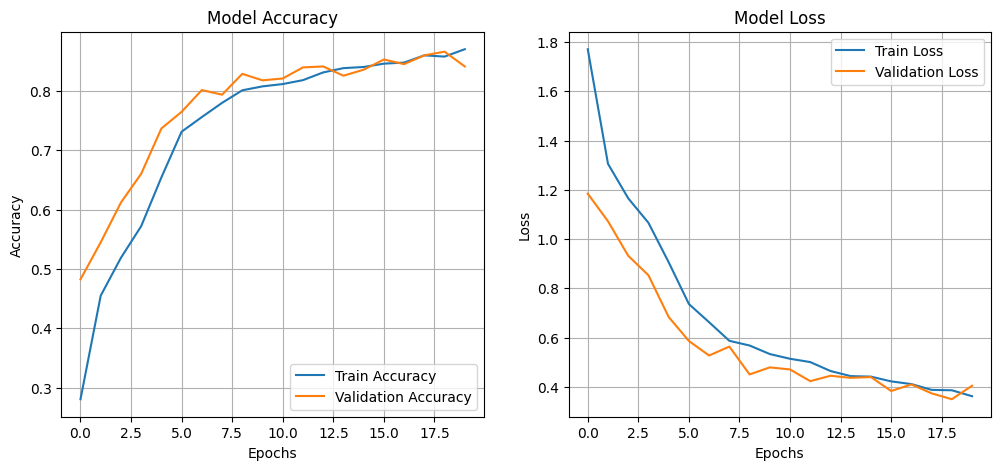

In [ ]:
def plot_training(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training(history)

In [1]:
# prompt: how to check version of numpy

import numpy as np
np.__version__


'2.0.2'

In [2]:
import pandas as pd
pd.__version__


'2.2.2'

In [3]:
# prompt: How to check version of scikitlearn

import sklearn
sklearn.__version__


'1.6.1'

In [4]:
import matplotlib
matplotlib.__version__


'3.10.0'

In [5]:
import seaborn
seaborn.__version__

'0.13.2'

In [6]:
import gradio
gradio.__version__


ModuleNotFoundError: No module named 'gradio'